In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [16]:
# get the path of the model
model_folder = '/home/ubuntu/epilepsy_project/Models/'
model_name = 'full_montage_MGH_PSG_OG_no_flip'
path_model = os.path.join(model_folder,model_name)

In [17]:
# get prediction dataframe from Backstage/Model_name
bonobo_pred = pd.read_csv(path_model+'/bonobo_pred.csv')
# get labels dataframe from Judge
path_bonobo_labels = os.path.join('..','Tables','testset_bonobo_events.csv')
bonobo_labels = pd.read_csv(path_bonobo_labels)


In [18]:
# add prediction of event file to labels
bonobo_all = bonobo_labels.merge(bonobo_pred, on='event_file', how='left')

# only look at samples rated by > 8 people
ultra_quality_filter = bonobo_all['total_votes_received']>=8
# only look at samples rated rated strong agreement
frac_filter = (bonobo_all['fraction_of_yes'] > 6/8) | (bonobo_all['fraction_of_yes'] < 2/8)

# apply filters
bonobo_all = bonobo_all[ultra_quality_filter & frac_filter]

In [19]:
# extract labels and predictions as lists
labels = bonobo_all.fraction_of_yes.round(0).astype(int)
preds = bonobo_all.preds.values

In [20]:
# calculate the roc curve for the model
fpr, tpr, thresholds = roc_curve(labels, preds)
# calculate the AUC
roc_auc = auc(fpr, tpr)

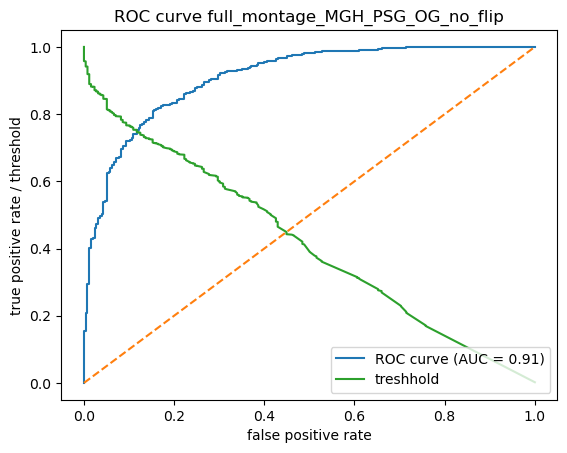

In [21]:
# plot the results

# workaround for tresholds are too high
thresholds[thresholds>1]=1
plt.plot(fpr,tpr,label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0, 1], linestyle='--')
plt.plot(fpr,thresholds,label='treshhold')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate / threshold')
plt.legend(loc="lower right")
plt.title('ROC curve '+model_name)
plt.savefig(path_model+'/Results/Easy_AUC.png')

In [22]:
# write brier score to text file
with open(path_model+'/Results/results.txt', 'a') as f:
    f.write('Easy AUC: '+str(roc_auc)+'\n')